https://www.kaggle.com/code/ohseokkim/predicting-future-by-lstm-prophet-neural-prophet/notebook

In [32]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [33]:
import neuralprophet

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch

In [35]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

데이터 불러오기

In [36]:
flight_data = pd.read_csv('C:\\data\\AirPassengers.csv')


In [37]:
flight_data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [38]:
flight_data[['year', 'month']] = flight_data['Month'].str.split('-', expand=True)
flight_data.drop('Month', axis=1, inplace=True)
flight_data.head()

,#Passengers,year,month
0,112,1949,01
1,118,1949,02
2,132,1949,03
3,129,1949,04
4,121,1949,05


In [39]:
flight_data.rename(columns={"#Passengers":"passengers"}, inplace=True)
flight_data

,passengers,year,month
0,112,1949,01
1,118,1949,02
2,132,1949,03
3,129,1949,04
4,121,1949,05
...,...,...,...
139,606,1960,08
140,508,1960,09
141,461,1960,10
142,390,1960,11


In [40]:
flight_data = flight_data[['year', 'month', 'passengers']]
print(flight_data)

     year month  passengers
0    1949    01         112
1    1949    02         118
2    1949    03         132
3    1949    04         129
4    1949    05         121
..    ...   ...         ...
139  1960    08         606
140  1960    09         508
141  1960    10         461
142  1960    11         390
143  1960    12         432

[144 rows x 3 columns]


In [41]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        144 non-null    object
 1   month       144 non-null    object
 2   passengers  144 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.5+ KB


In [42]:
flight_data[['year', 'month']] = flight_data[['year', 'month']].apply(lambda x:x.astype(int))
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        144 non-null    int32
 1   month       144 non-null    int32
 2   passengers  144 non-null    int64
dtypes: int32(2), int64(1)
memory usage: 2.4 KB


In [43]:
print(flight_data.describe())
print('-'*40)
print(flight_data.tail())

              year       month  passengers
count   144.000000  144.000000  144.000000
mean   1954.500000    6.500000  280.298611
std       3.464102    3.464102  119.966317
min    1949.000000    1.000000  104.000000
25%    1951.750000    3.750000  180.000000
50%    1954.500000    6.500000  265.500000
75%    1957.250000    9.250000  360.500000
max    1960.000000   12.000000  622.000000
----------------------------------------
     year  month  passengers
139  1960      8         606
140  1960      9         508
141  1960     10         461
142  1960     11         390
143  1960     12         432


In [44]:
flight_data.shape

(144, 3)

In [45]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        144 non-null    int32
 1   month       144 non-null    int32
 2   passengers  144 non-null    int64
dtypes: int32(2), int64(1)
memory usage: 2.4 KB


시각화

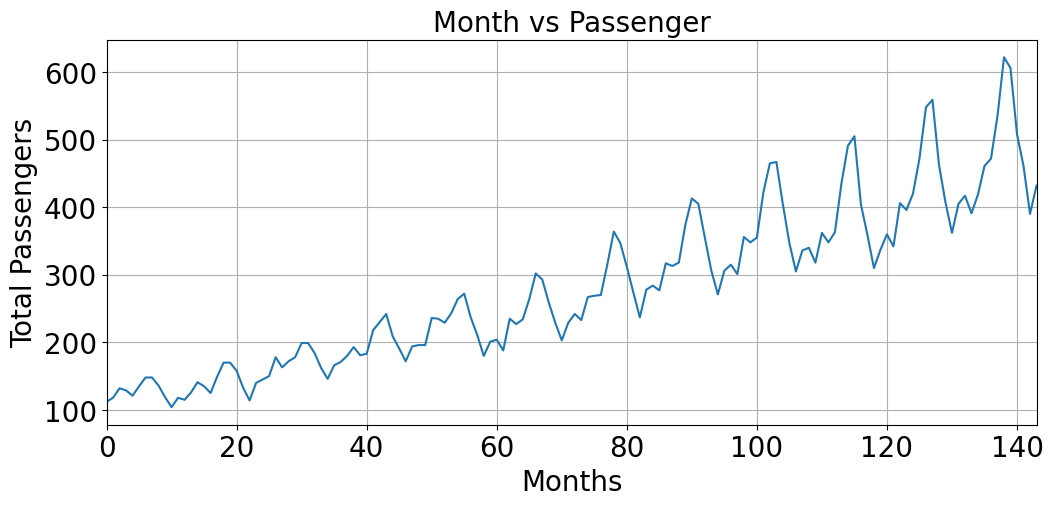

In [46]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger', fontsize=20)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Total Passengers', fontsize=20)
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['passengers'])

요소분해(seasonal_decomposition)

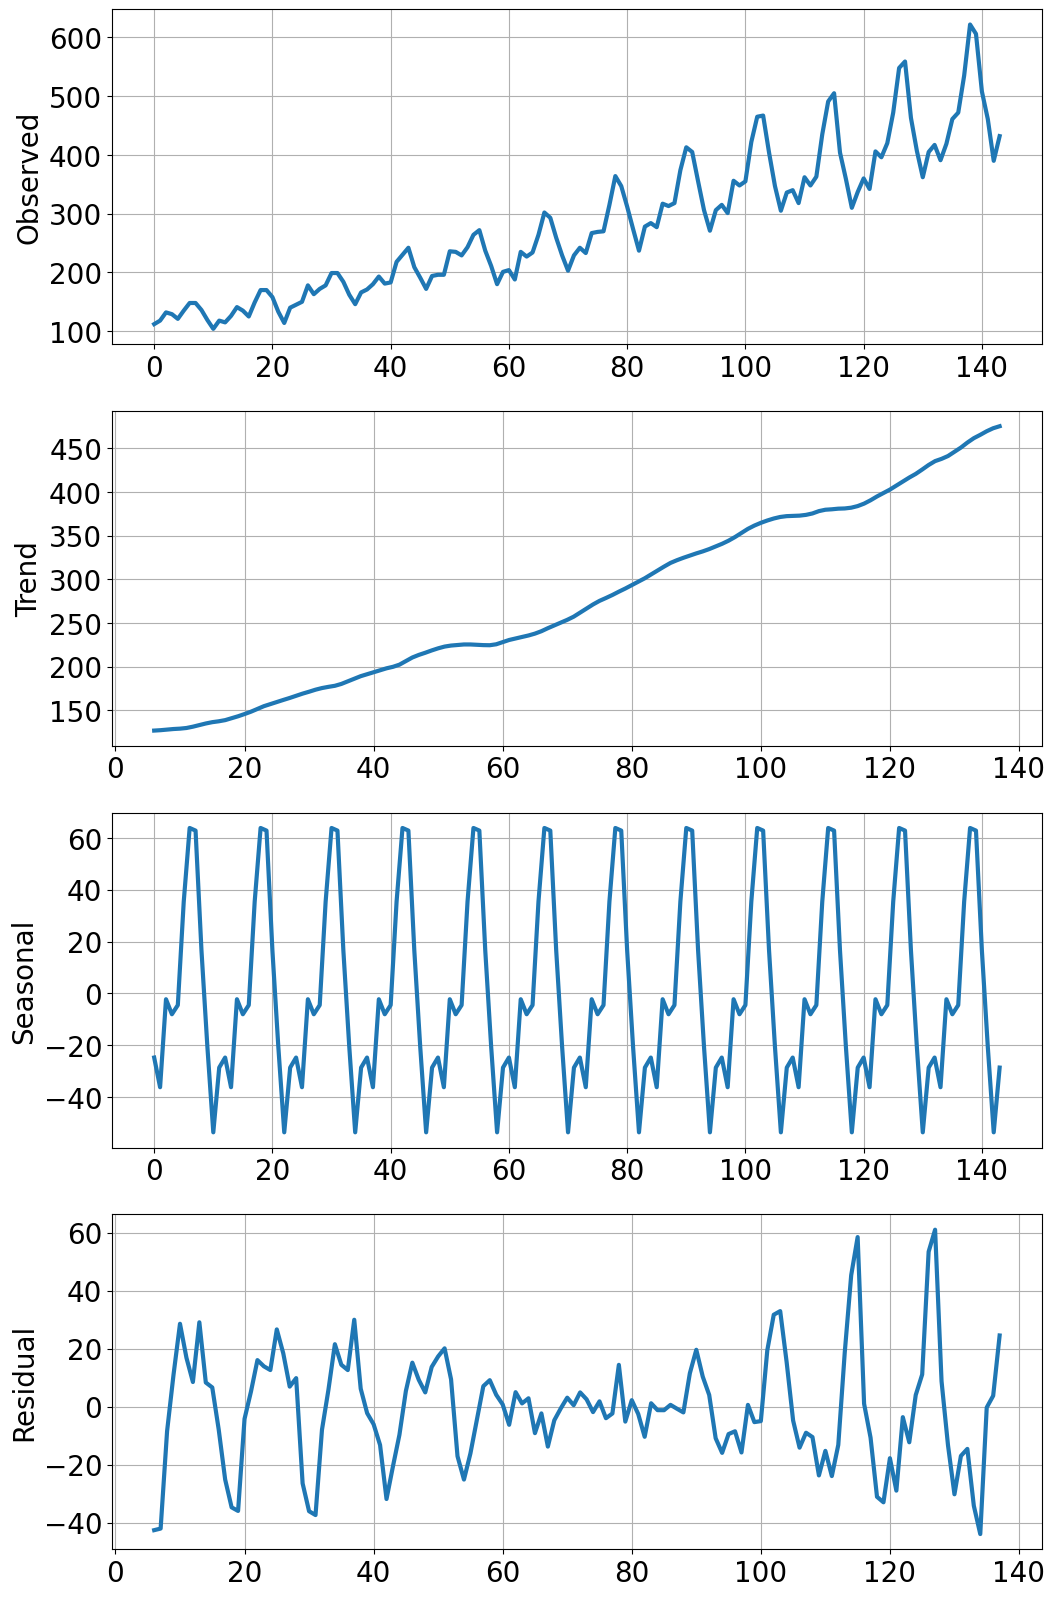

In [47]:
import statsmodels
import statsmodels.api as sm 
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(flight_data['passengers'], period=12)
plot_decompose(decomposition)

데이터 전처리

In [48]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)
print(all_data.shape)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]
(144,)


In [49]:
test_data_size = 12
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [50]:
print(len(train_data))
print(len(test_data))

132
12


In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))

In [52]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

utility function 

In [53]:
train_window = 12

In [54]:
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [55]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [56]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

Modeling using LSTM

In [57]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F 

In [58]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size= hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [59]:
model = LSTM()
loss_function = nn.MSELoss()
optimier = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
print(model)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


훈련

In [62]:
epochs = 500
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimier.zero_grad()
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimier.step()
        
    if i%25 ==1:
        print(f'epoch:{i:3} loss: {single_loss.item(): 10.8f}')
print(f'epoch:{i:3} loss: {single_loss.item(): 10.8f}')

epoch:  0 loss:  0.05250913
epoch:  1 loss:  0.01906461
epoch:  2 loss:  0.00105198
epoch:  3 loss:  0.53865707
epoch:  4 loss:  0.03127714
epoch:  5 loss:  0.07106530
epoch:  6 loss:  0.15155970
epoch:  7 loss:  0.15789461
epoch:  8 loss:  0.14321285
epoch:  9 loss:  0.07701049
epoch: 10 loss:  0.06756408
epoch: 11 loss:  0.16854151
epoch: 12 loss:  0.20812045
epoch: 13 loss:  0.22435455
epoch: 14 loss:  0.23349516
epoch: 15 loss:  0.23919524
epoch: 16 loss:  0.24306123
epoch: 17 loss:  0.24584718
epoch: 18 loss:  0.24794485
epoch: 19 loss:  0.24957567
epoch: 20 loss:  0.25087440
epoch: 21 loss:  0.25192785
epoch: 22 loss:  0.25279477
epoch: 23 loss:  0.25351655
epoch: 24 loss:  0.25412327
epoch: 25 loss:  0.25463703
epoch: 26 loss:  0.25507510
epoch: 27 loss:  0.25545055
epoch: 28 loss:  0.25577378
epoch: 29 loss:  0.25605318
epoch: 30 loss:  0.25629553
epoch: 31 loss:  0.25650662
epoch: 32 loss:  0.25669143
epoch: 33 loss:  0.25685343
epoch: 34 loss:  0.25699568
epoch: 35 loss:  0.2

In [63]:
fut_pred = 12
test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [64]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

In [65]:
test_inputs[fut_pred:]

[0.24983255565166473,
 0.3153567314147949,
 0.3803682029247284,
 0.3715520203113556,
 0.540310800075531,
 0.6322776675224304,
 0.7392065525054932,
 0.755336344242096,
 0.4216020703315735,
 0.18401911854743958,
 0.32977429032325745,
 0.225595161318779]

In [66]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
print(actual_predictions)

[[388.33690641]
 [403.2436564 ]
 [418.03376617]
 [416.02808462]
 [454.42070702]
 [475.34316936]
 [499.66949069]
 [503.33901832]
 [427.414471  ]
 [373.36434947]
 [406.52365105]
 [382.8228992 ]]


In [67]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


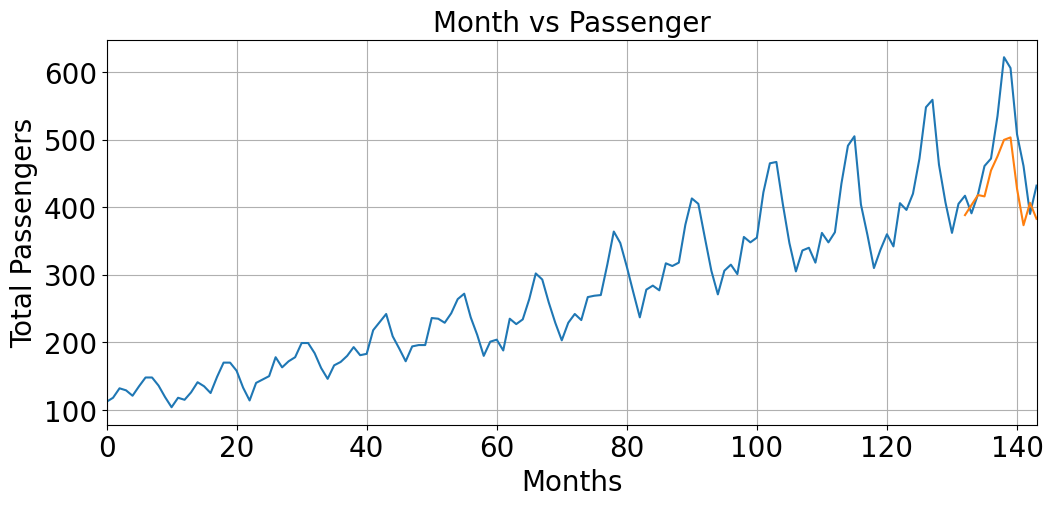

In [68]:
plt.figure(figsize=(12, 5))
plt.title('Month vs Passenger', fontsize=20)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Total Passengers', fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['passengers'])
plt.plot(x, actual_predictions)

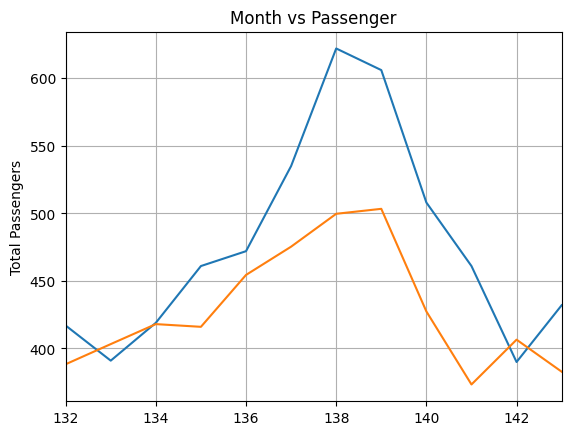

In [69]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x, actual_predictions)
plt.show()

In [70]:
flight_data['passengers'][:-train_window]
train_df = pd.DataFrame(flight_data['passengers'][:-train_window])
actual_df = pd.DataFrame(actual_predictions)
actual_df.columns = ['passengers']
new_predict = pd.concat([train_df, actual_df]).reset_index(drop=True)

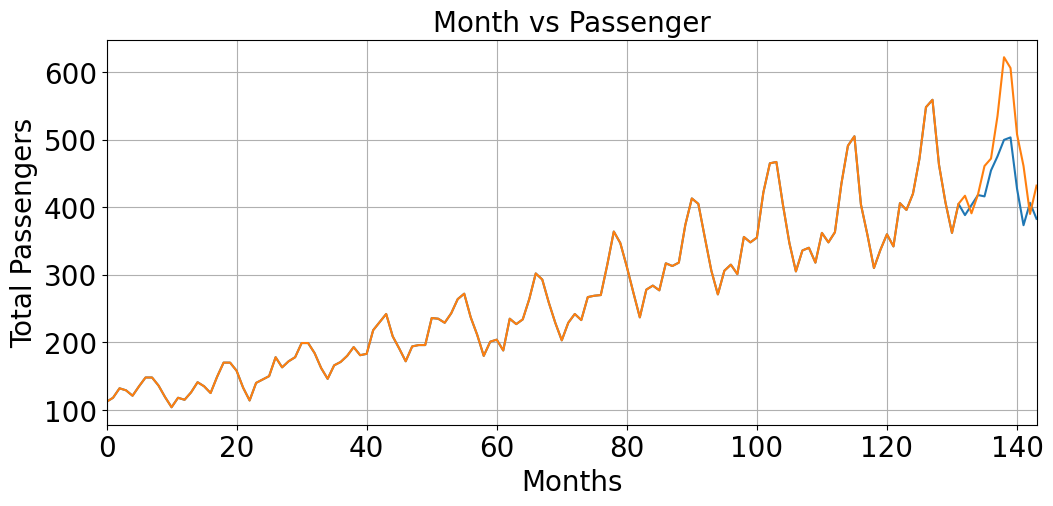

In [71]:
plt.figure(figsize=(12, 5))
plt.title('Month vs Passenger', fontsize=20)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Total Passengers', fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(new_predict)
plt.plot(flight_data['passengers'])

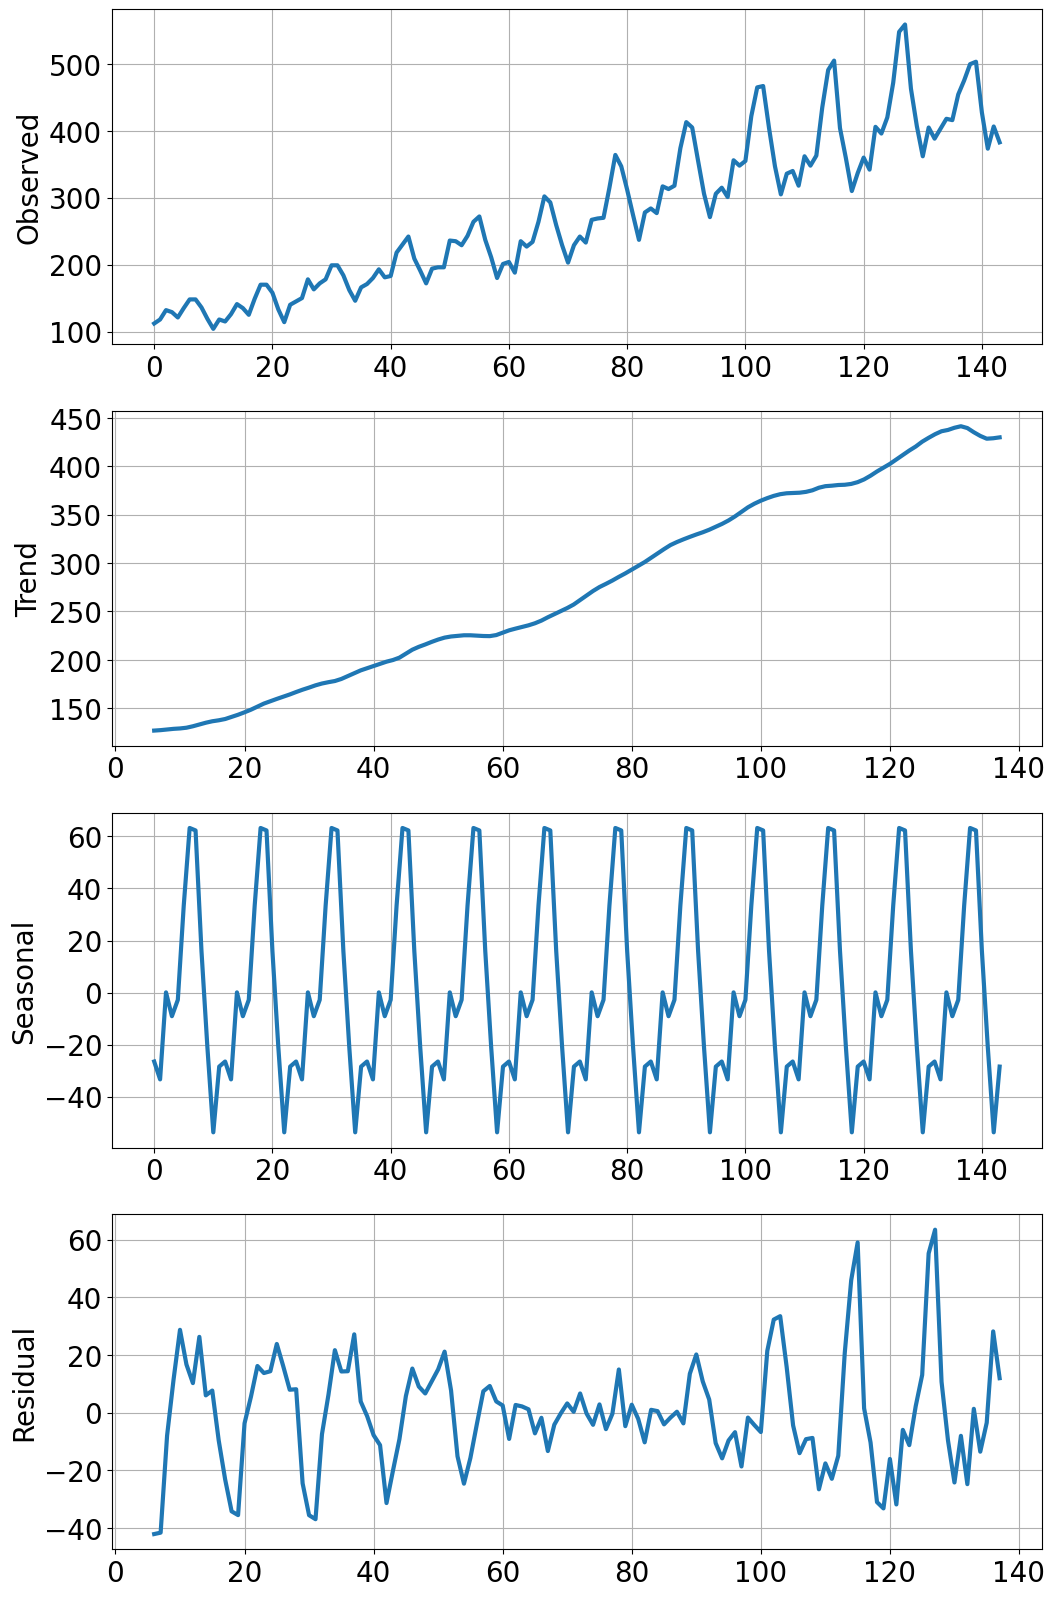

In [72]:
decomposition = seasonal_decompose(new_predict, period=12)
plot_decompose(decomposition)